# Use sklearn to analyze misclassified samples

- To do:
  1. Find a way to visualize algorithm decisions
     - Make graphs comparing ERBB2 and something else

- Notes:
  - Lime does *_not_* work in `Jupyter Lab`

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz

In [2]:
# Found on http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [3]:
# This returns the indices where two lists do not match values
#NOTE: Lists must be of equal length

def compare_lists(x, y):
    discrepancies = []
    for i in range(len(x)):
        if x[i] != y[i]:
            discrepancies.append(i)
    return discrepancies

In [4]:
# Load data that has been previously classified by SVM
svm_data = pd.read_csv("../data/svm_genes_TPM.tsv.gz", sep="\t")
# Grab only the HER2 Positive samples
svm_data = svm_data[svm_data['her2_status_by_ihc'] == "Positive"]

In [5]:
# Load data that has been previously classified by RandomForest
rf_data = pd.read_csv("../data/rf_genes_TPM.tsv.gz", sep="\t")

In [6]:

svm_expr = svm_data.iloc[:,:-3]
svm_target = pd.DataFrame(data=svm_data['SVM_classified'])
svm_target['SVM_classified'] = (svm_target['SVM_classified'] == "Correct").astype(int)

## Random Forest on misclassified samples

#### __NOTE:__ uses graphviz to create trees, which is not installed in this docker container, meaning I must convert them to pdf format on my laptop

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

auc_vals = []
ix = 0

for train, test in kf.split(svm_expr, svm_target):
    clf = RandomForestClassifier(random_state=0)
    
    X_train, X_test = svm_expr.values[train], svm_expr.values[test]
    y_train, y_test = svm_target.values[train], svm_target.values[test]
    
    clf.fit(X_train, y_train.ravel())
    
    testing_ids = svm_data['Sample'].values[test]
    
    predictions = clf.predict(X_test)
    
    misclassied = compare_lists(y_test.ravel(), predictions)
    
    print(testing_ids[misclassied])
    
    print(roc_auc_score(y_test.ravel(), predictions))
    
    export_graphviz(clf.estimators_[0],
                    out_file='_'.join(["../temp/misclassied", str(ix), "tree.dot"]),
                    feature_names=list(svm_expr),
                    class_names=["Misclassified", "Correct"],
                    filled=True,
                    rounded=True)
    ix += 1


['TCGA-A2-A0CX-01A-21R-A00Z-07' 'TCGA-A2-A0YG-01A-21R-A109-07'
 'TCGA-A8-A07I-01A-11R-A00Z-07' 'TCGA-BH-A1EV-01A-11R-A137-07'
 'TCGA-C8-A12Q-01A-11R-A115-07']
0.75
['TCGA-A8-A08B-01A-11R-A00Z-07' 'TCGA-AN-A04C-01A-21R-A034-07'
 'TCGA-AO-A03L-01A-41R-A056-07' 'TCGA-AO-A0JE-01A-11R-A056-07'
 'TCGA-EW-A1IW-01A-11R-A13Q-07']
0.80652173913
['TCGA-3C-AALI-01A-11R-A41B-07' 'TCGA-A2-A3XZ-01A-42R-A239-07'
 'TCGA-AN-A0FV-01A-11R-A00Z-07' 'TCGA-AO-A0JM-01A-21R-A056-07'
 'TCGA-BH-A0DZ-01A-11R-A00Z-07' 'TCGA-D8-A27N-01A-11R-A16F-07']
0.728260869565
['TCGA-A1-A0SM-01A-11R-A084-07' 'TCGA-A2-A0T1-01A-21R-A084-07'
 'TCGA-A8-A09G-01A-21R-A00Z-07' 'TCGA-BH-A0AW-01A-11R-A056-07'
 'TCGA-BH-A0B7-01A-12R-A115-07' 'TCGA-C8-A137-01A-11R-A115-07'
 'TCGA-D8-A1JA-01A-11R-A13Q-07' 'TCGA-E2-A14P-01A-31R-A12D-07']
0.627272727273
['TCGA-3C-AALK-01A-11R-A41B-07' 'TCGA-A8-A076-01A-21R-A00Z-07'
 'TCGA-AQ-A0Y5-01A-11R-A14M-07' 'TCGA-C8-A8HP-01A-11R-A36F-07'
 'TCGA-E2-A14V-01A-11R-A12D-07' 'TCGA-E2-A1LB-01A-11R-A144-07']


## Gaussian Process

['TCGA-A2-A0CX-01A-21R-A00Z-07' 'TCGA-A2-A0YG-01A-21R-A109-07'
 'TCGA-A8-A07I-01A-11R-A00Z-07' 'TCGA-BH-A0HY-01A-11R-A056-07'
 'TCGA-BH-A1EV-01A-11R-A137-07' 'TCGA-BH-A202-01A-11R-A14M-07'
 'TCGA-C8-A12Q-01A-11R-A115-07' 'TCGA-C8-A135-01A-11R-A115-07'
 'TCGA-C8-A1HK-01A-21R-A13Q-07' 'TCGA-D8-A1J9-01A-11R-A13Q-07']
0.5


ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

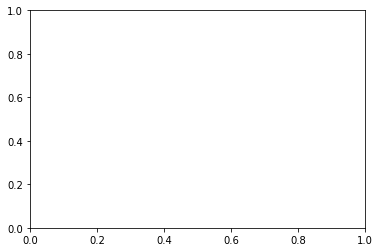

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

auc_vals = []
ix = 0

erbb2_ix = svm_data.columns.get_loc('ERBB2')
igf1r_ix = svm_data.columns.get_loc('IGF1R')


for train, test in kf.split(svm_expr, svm_target):
    clf = GaussianProcessClassifier(random_state=0)
    
    X_train, X_test = svm_expr.values[train], svm_expr.values[test]
    y_train, y_test = svm_target.values[train], svm_target.values[test]
    
    clf.fit(X_train, y_train.ravel())
    
    testing_ids = svm_data['Sample'].values[test]
    
    predictions = clf.predict(X_test)
    
    misclassied = compare_lists(y_test.ravel(), predictions)
    
    print(testing_ids[misclassied])
    
    print(roc_auc_score(y_test.ravel(), predictions))
    
    plot_decision_regions(X=X_test[:,[erbb2_ix, igf1r_ix]],
                         y=y_test.ravel(), clf=clf, legend=2)
    
    ix += 1
    

    

## SVM on misclassified samples

['TCGA-A2-A0YG-01A-21R-A109-07' 'TCGA-A8-A07I-01A-11R-A00Z-07'
 'TCGA-BH-A1EV-01A-11R-A137-07' 'TCGA-C8-A12Q-01A-11R-A115-07']
0.8


/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


['TCGA-A8-A08B-01A-11R-A00Z-07' 'TCGA-AN-A04C-01A-21R-A034-07'
 'TCGA-AO-A0JE-01A-11R-A056-07' 'TCGA-BH-A18R-01A-11R-A12D-07'
 'TCGA-BH-A18U-01A-21R-A12D-07' 'TCGA-C8-A12P-01A-11R-A115-07'
 'TCGA-E2-A1B0-01A-11R-A12P-07' 'TCGA-EW-A1IW-01A-11R-A13Q-07']
0.628260869565


KeyboardInterrupt: 

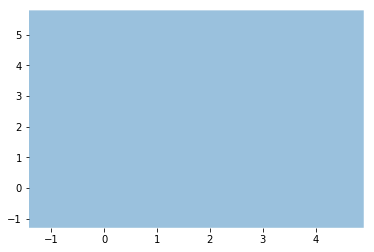

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

auc_vals = []

filler_vals = {k:0 for k,v in enumerate(list(svm_data)) if v not in ['ERBB2', 'IFG1R', 'Sample', 'her2_status_by_ihc', 'SVM_classified']}
#print(filler_vals)

for train, test in kf.split(svm_expr, svm_target):
    clf = SVC(random_state=0)
    
    X_train, X_test = svm_expr.values[train], svm_expr.values[test]
    y_train, y_test = svm_target.values[train], svm_target.values[test]
    
    clf.fit(X_train, y_train.ravel())
    
    testing_ids = svm_data['Sample'].values[test]
    
    predictions = clf.predict(X_test)
    
    misclassied = compare_lists(y_test.ravel(), predictions)
    
    print(testing_ids[misclassied])
    
    print(roc_auc_score(y_test.ravel(), predictions))
    
    
    
    plot_decision_regions(X=X_test,
                         y=y_test.ravel(), clf=clf, legend=2, feature_index=[erbb2_ix, igf1r_ix],
                          filler_feature_values=filler_vals)

## Multi-layer Perceptron on this biz

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

auc_vals = []

for train, test in kf.split(svm_expr, svm_target):
    clf = MLPClassifier(random_state=0)
    
    X_train, X_test = svm_expr.values[train], svm_expr.values[test]
    y_train, y_test = svm_target.values[train], svm_target.values[test]
    
    clf.fit(X_train, y_train.ravel())
    
    testing_ids = svm_data['Sample'].values[test]
    
    predictions = clf.predict(X_test)
    
    misclassied = compare_lists(y_test.ravel(), predictions)
    
    print(testing_ids[misclassied])
    
    print(roc_auc_score(y_test.ravel(), predictions))

['TCGA-A2-A0CX-01A-21R-A00Z-07' 'TCGA-A2-A0D1-01A-11R-A034-07'
 'TCGA-A8-A075-01A-11R-A084-07' 'TCGA-A8-A07I-01A-11R-A00Z-07'
 'TCGA-A8-A07R-01A-21R-A034-07' 'TCGA-AC-A2FB-01A-11R-A17B-07'
 'TCGA-AQ-A04L-01B-21R-A10J-07' 'TCGA-AR-A24U-01A-11R-A169-07'
 'TCGA-BH-A1EN-01A-11R-A13Q-07' 'TCGA-BH-A202-01A-11R-A14M-07']
0.697826086957
['TCGA-A2-A04W-01A-31R-A115-07' 'TCGA-AC-A8OS-01A-12R-A41B-07'
 'TCGA-AN-A04C-01A-21R-A034-07' 'TCGA-AO-A0JE-01A-11R-A056-07'
 'TCGA-AO-A12D-01A-11R-A115-07' 'TCGA-BH-A18R-01A-11R-A12D-07'
 'TCGA-BH-A18U-01A-21R-A12D-07' 'TCGA-C8-A12Z-01A-11R-A115-07'
 'TCGA-EW-A1IW-01A-11R-A13Q-07' 'TCGA-EW-A6S9-01A-22R-A33J-07']
0.584782608696
['TCGA-3C-AALI-01A-11R-A41B-07' 'TCGA-A7-A2KD-01A-31R-A21T-07'
 'TCGA-A8-A09I-01A-22R-A034-07' 'TCGA-AC-A23C-01A-12R-A169-07'
 'TCGA-AO-A0JM-01A-21R-A056-07' 'TCGA-AR-A254-01A-21R-A169-07'
 'TCGA-BH-A0DZ-01A-11R-A00Z-07' 'TCGA-D8-A27N-01A-11R-A16F-07']
0.684782608696
['TCGA-A2-A0T1-01A-21R-A084-07' 'TCGA-BH-A0AW-01A-11R-A056-07'
 'TCGA-